Clasificación de imágenes --- 0:00 min
===

* Última modificación: Marzo 1, 2022 | YouTube

Importación de librerías
---

In [3]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Descarga de archivos de ejemplo de TensorFlow
---

In [5]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(
    # -----------------------------------------------------------------------------------
    # Ubicacion donde seran guardados los archivos
    fname="flower_photos",
    # -----------------------------------------------------------------------------------
    # Direccion web de los archivos
    origin=dataset_url,
    # -----------------------------------------------------------------------------------
    # Extracción de archivos tar, zip, ...
    untar=True,
    # -----------------------------------------------------------------------------------
    # Directorio para almacenamiento de los datos
    cache_subdir="/tmp/flower_photos",
)
data_dir

228827136/228813984 [==============================] - 88s 0us/step


'/tmp/flower_photos/flower_photos'

In [6]:
import pathlib

#
# Crea un objeto para manipular los archivos
#
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/tmp/flower_photos/flower_photos')

Contenido de la carpeta de ejemplos
---

In [7]:
#
# Directorios
#
!ls -1 /tmp/flower_photos/

LICENSE.txt
daisy
dandelion
flower_photos
flower_photos.tar.gz
roses
sunflowers
tulips


In [8]:
#
# Cantidad de archivos
#
len(list(data_dir.glob("*/*.jpg")))

3670

Visualización de algunas imágenes
---

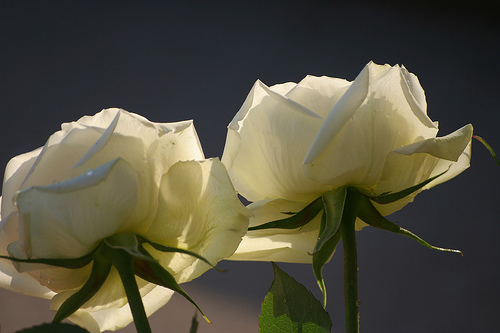

In [9]:
import PIL

roses = list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[0]))

Carga directa de los datos desde el directorio usando Keras
---

In [10]:
#
# Parámetros
#
params = {
    "directory": data_dir,
    "validation_split": 0.2,
    "seed": 12345,
    "image_size": (180, 180),
    "batch_size": 32,
}

train_params = {**params, **{"subset": "training"}}
val_params = {**params, **{"subset": "validation"}}

In [11]:
#
# Datos para entrenamiento
#
train_ds = tf.keras.utils.image_dataset_from_directory(**train_params)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
#
# Datos para validación
#
val_ds = tf.keras.utils.image_dataset_from_directory(**val_params)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
#
# Nombres de las clases
#
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Visualización de los datos
---

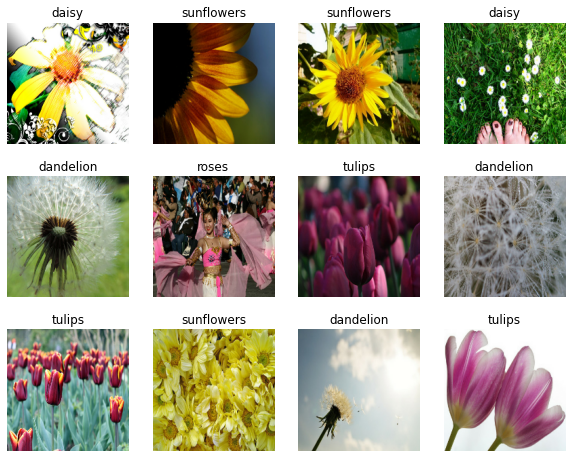

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Iteración manual sobre el dataset
---

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


Configuración del dataset para el desempeño
---

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

#
# cache: mantiene las images en memoria despues de la primera lectura
# prefetch: traslapa la lectura del bloque s+1 con el entrenamiento del bloque s.
# Ver: https://www.tensorflow.org/guide/data_performance#prefetching
#
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Escalamiento de los datos
---

In [17]:
rescaling_layer = tf.keras.layers.Rescaling(1.0 / 255)

In [18]:
#
# Aplicación de la capa de escalado
#
rescaled_ds = train_ds.map(lambda x, y: (rescaling_layer(x), y))

image_batch, labels_batch = next(iter(rescaled_ds))

In [20]:
#
# Dimensiones de la primera imagen
#
import numpy as np

first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


Creación del modelo
---

In [23]:
num_classes = len(class_names)

model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255, input_shape=(180, 180, 3)),
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)

Compilación del modelo
---

In [24]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

Resumen del modelo
---

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Entrenamiento del modelo
---

In [26]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
92/92 [==============================] - 28s 295ms/step - loss: 1.3808 - accuracy: 0.4462 - val_loss: 1.2215 - val_accuracy: 0.4809
Epoch 2/10
92/92 [==============================] - 25s 269ms/step - loss: 1.0013 - accuracy: 0.6144 - val_loss: 1.0278 - val_accuracy: 0.5954
Epoch 3/10
92/92 [==============================] - 36s 388ms/step - loss: 0.8159 - accuracy: 0.6945 - val_loss: 0.9473 - val_accuracy: 0.6199
Epoch 4/10
92/92 [==============================] - 26s 283ms/step - loss: 0.6155 - accuracy: 0.7735 - val_loss: 1.0196 - val_accuracy: 0.6335
Epoch 5/10
92/92 [==============================] - 28s 307ms/step - loss: 0.4110 - accuracy: 0.8590 - val_loss: 1.0583 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 28s 299ms/step - loss: 0.2627 - accuracy: 0.9155 - val_loss: 1.3981 - val_accuracy: 0.5926
Epoch 7/10
92/92 [==============================] - 27s 292ms/step - loss: 0.1395 - accuracy: 0.9615 - val_loss: 1.8258 - val_accuracy: 0.6063

Visualización de los resultados
---

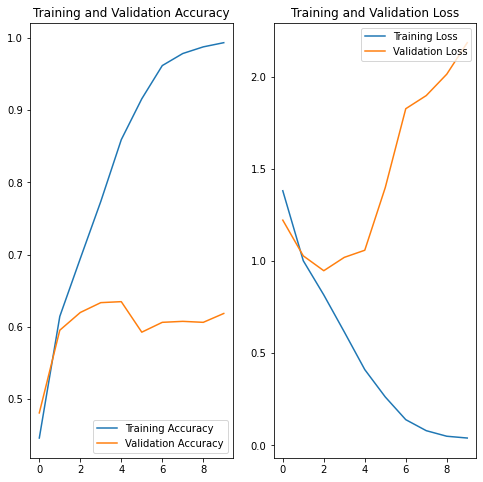

In [34]:
import matplotlib.pyplot as plt


def plot_history(history, epochs):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()


plot_history(history, epochs)

Sobreajuste
---

![flowers-overfitting.png](assets/flowers-overfitting.png)

Data augmentation
----

In [28]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(
            "horizontal",
            input_shape=(180, 180, 3),
        ),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)

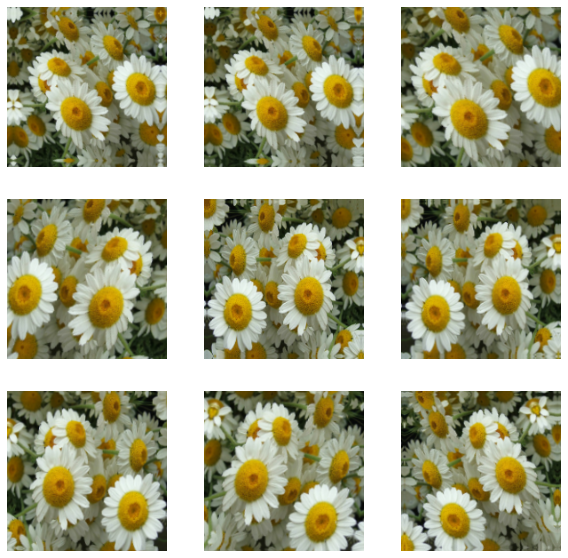

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Dropout
---

In [31]:
model = tf.keras.Sequential(
    [
        data_augmentation,
        tf.keras.layers.Rescaling(1.0 / 255),
        tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)

Compilación y entrenamiento del modelo
----

In [32]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [36]:
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
92/92 [==============================] - 31s 314ms/step - loss: 1.4769 - accuracy: 0.3566 - val_loss: 1.1332 - val_accuracy: 0.5204
Epoch 2/15
92/92 [==============================] - 28s 309ms/step - loss: 1.1425 - accuracy: 0.5392 - val_loss: 1.0883 - val_accuracy: 0.5804
Epoch 3/15
92/92 [==============================] - 28s 301ms/step - loss: 1.0529 - accuracy: 0.5743 - val_loss: 0.9679 - val_accuracy: 0.6117
Epoch 4/15
92/92 [==============================] - 27s 297ms/step - loss: 0.9699 - accuracy: 0.6315 - val_loss: 1.0108 - val_accuracy: 0.6117
Epoch 5/15
92/92 [==============================] - 30s 321ms/step - loss: 0.9202 - accuracy: 0.6485 - val_loss: 0.9484 - val_accuracy: 0.6362
Epoch 6/15
92/92 [==============================] - 31s 336ms/step - loss: 0.8949 - accuracy: 0.6570 - val_loss: 0.9811 - val_accuracy: 0.6090
Epoch 7/15
92/92 [==============================] - 30s 322ms/step - loss: 0.8099 - accuracy: 0.6993 - val_loss: 0.8655 - val_accuracy: 0.6594

Visualización de resultados
---

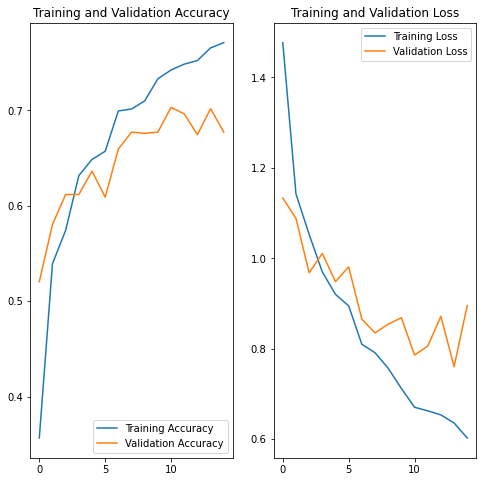

In [37]:
plot_history(history, epochs)

Predicción para nuevos datos
---

In [38]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"

sunflower_path = tf.keras.utils.get_file(
    "Red_sunflower",
    origin=sunflower_url,
    cache_subdir="/tmp",
)

img = tf.keras.utils.load_img(sunflower_path, target_size=(180, 180))

img_array = tf.keras.utils.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)  

predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(
        class_names[np.argmax(score)], 100 * np.max(score)
    )
)

131072/117948 [=================================] - 0s 2us/step
This image most likely belongs to sunflowers with a 97.52 percent confidence.
